Import section

In [1]:
import pandas as pd
import csv
import matplotlib as plt
import matplotlib.pyplot as plt

import numpy as np
#import googletrans
#from googletrans import Translator
from google_trans_new import google_translator  
import nltk
#nltk.download()
import os
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from langdetect import detect
from collections import Counter
from itertools import combinations
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [2]:
def lower_case_titles(df):
    df['title_tokenized_lower'] = "empty"
    for i in range(0, len(items)):
        help1 = [word.lower() for word in items.iloc[i]['title_tokenized']]
        items.at[i, 'title_tokenized_lower'] = help1
        print(i)
    return items

In [3]:
def delete_non_alphabetics(items):
    items['title_tokenized_lower_isalpha'] = "empty"
    # delete non-alphabetics
    for i in range(0, len(items)):
        help1 = [word for word in items.iloc[i]['title_tokenized_lower'] if word.isalpha()]
        items.at[i, 'title_tokenized_lower_isalpha'] = help1
        #print(i)
    return items

In [4]:
def delete_stopwords(items):
    # feature: stopwords
    items['title_tokenized_lower_isalpha_stopwords'] = 'empty'
    for i in range(0, len(items)):
        help1 = [word for word in items.iloc[i]['title_tokenized_lower_isalpha'] if not word in stop_words]
        items.at[i, 'title_tokenized_lower_isalpha_stopwords'] = help1
    return items 

In [5]:
# insert language feature and create stem words
def language_and_stemwords(items):    
    items['title_tokenized_lower_isalpha_stopwords_stemwords'] = 'empty'
    items['language'] = 'empty'
    # stemmer for english, german and french
    stemmer_en = SnowballStemmer('english')
    stemmer_de = SnowballStemmer('german')
    stemmer_fr = SnowballStemmer('french')
    stemmer_es = SnowballStemmer('spanish')
    for i in range(0,len(items)):
        title = items.iloc[i]['title']
        if (len(title) >= 3) and (any(word.isalpha() for word in title) == True):
            if (len(title.split()) ==1) and (title.isalnum() == False):
                items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords'] = 'NaN'
                print(str(i) + ' ' + str(title) + ', title is problematic')
            else:            
                lang = detect(title)
                items.at[i, 'language'] = lang
                if lang == 'en':
                    stemmed_en = [stemmer_en.stem(word) for word in items.iloc[i]['title_tokenized_lower_isalpha_stopwords']]
                    items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords'] = stemmed_en
                    print(str(i) + ' en')
                elif lang == 'de':
                    stemmed_de = [stemmer_de.stem(word) for word in items.iloc[i]['title_tokenized_lower_isalpha_stopwords']]
                    items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords'] = stemmed_de 
                    print(str(i) + ' de')
                elif (detect(title) == 'fr'):
                    stemmed_fr = [stemmer_fr.stem(word) for word in items.iloc[i]['title_tokenized_lower_isalpha_stopwords']]
                    items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords'] = stemmed_fr
                    print(str(i) + ' fr')
                elif (detect(title) == 'es'):
                    stemmed_es = [stemmer_es.stem(word) for word in items.iloc[i]['title_tokenized_lower_isalpha_stopwords']]
                    items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords'] = stemmed_es
                    print(str(i) + ' es')    
                else:
                    items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords'] = items.iloc[i]['title_tokenized_lower_isalpha_stopwords']
                    print(str(i) + ' lang detected but not in set: ' + str(lang) )
        else:
            #language cannot be detected
            items.at[i, 'language'] = 'NaN' 
            items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords'] = items.iloc[i]['title_tokenized_lower_isalpha_stopwords']
            print(str(i) + ' ' + str(title) + ', language cannot be detected')
    return items

In [6]:
def lang_detect(df):
    df['language_title'] = 'NaN'
    for i in range(0,len(df)):
        title = df.iloc[i]['title']
        lang = detect(title)
        df.at[i, 'language_title'] = lang
        print(str(title) + ', ' + str(lang))
    return df

In [7]:
# create strings out of preprocessed word stems
def create_string(items):
    items['title_tokenized_lower_isalpha_stopwords_stemwords_str'] = 'empty'
    for i in range(0, len(items)):
        string = ' '.join(items.iloc[i]['title_tokenized_lower_isalpha_stopwords_stemwords'])
        items.at[i, 'title_tokenized_lower_isalpha_stopwords_stemwords_str'] = string
        #print(i)
    return items    

In [8]:
# create strings out of preprocessed word stems
def create_string_topic(items):
    items['main_topic_split_string'] = ''
    for i in range(0, len(items)):
        string = ' '.join(items.iloc[i]['main_topic_split'])
        items.at[i, 'main_topic_split_string'] = string
        #print(i)
    return items    

# Prepare Data 

load preprocessing script from Hao

In [ ]:
items = pd.read_pickle('items_preprocessed.pkl')
items = items.reset_index()

In [ ]:
# read all external data
items_ex = pd.read_pickle('External_Data_incl_Features.pkl')
items_ex = items_ex.reset_index()

In [ ]:
tx = pd.read_pickle('transactions_preprocessed.pkl')

In [ ]:
# read evaluation CSV
evaluation = pd.read_csv("./evaluation.csv", sep="|", quoting = csv.QUOTE_NONE)

merge dataframes

In [ ]:
df = pd.merge(tx, items, on='itemID')

##### external dataset

In [11]:
# load 'rules_order' from pickle
with open('result_fuzzy_matching.pkl', 'rb') as f:
    items_ext = pickle.load(f)
items_ext = items_ext.reset_index()    

## Clustering by Main Topic

##### preprocess whole items dataset for main topic clustering

In [13]:
items = pd.read_pickle('items_preprocessed.pkl')
items = items.reset_index()

In [15]:
def split(word): 
    return [char for char in word] 

In [16]:
items['main_topic_split'] = ''
for i in range(0, len(items)):
    list_char = split(items.iloc[i]['main topic'])
    items.at[i, 'main_topic_split'] = list_char

In [17]:
items = create_string_topic(items)

In [20]:
# get only items with main topic of at least 3 characters -> 2 letters
mask = (items['main_topic_split_string'].str.len() >=2)
items = items.loc[mask]

In [63]:
# create feature for top topic of book, i.e. the first letter that appears
items['main_topic_A'] = items['main topic'].str.startswith('A')
items['main_topic_C'] = items['main topic'].str.startswith('C')
items['main_topic_D'] = items['main topic'].str.startswith('D')
items['main_topic_F'] = items['main topic'].str.startswith('F')
items['main_topic_G'] = items['main topic'].str.startswith('G')
items['main_topic_J'] = items['main topic'].str.startswith('J')
items['main_topic_K'] = items['main topic'].str.startswith('K')
items['main_topic_L'] = items['main topic'].str.startswith('L')
items['main_topic_M'] = items['main topic'].str.startswith('M')
items['main_topic_N'] = items['main topic'].str.startswith('N')
items['main_topic_P'] = items['main topic'].str.startswith('P')
items['main_topic_Q'] = items['main topic'].str.startswith('Q')
items['main_topic_R'] = items['main topic'].str.startswith('R')
items['main_topic_S'] = items['main topic'].str.startswith('S')
items['main_topic_T'] = items['main topic'].str.startswith('T')
items['main_topic_U'] = items['main topic'].str.startswith('U')
items['main_topic_V'] = items['main topic'].str.startswith('V')
items['main_topic_W'] = items['main topic'].str.startswith('W')
items['main_topic_X'] = items['main topic'].str.startswith('X')
items['main_topic_Y'] = items['main topic'].str.startswith('Y')
items['main_topic_1'] = items['main topic'].str.startswith('1')
items['main_topic_2'] = items['main topic'].str.startswith('2')
items['main_topic_3'] = items['main topic'].str.startswith('3')
items['main_topic_4'] = items['main topic'].str.startswith('4')
items['main_topic_5'] = items['main topic'].str.startswith('5')
items['main_topic_6'] = items['main topic'].str.startswith('6')

In [94]:
#### KMeans https://www.youtube.com/watch?v=ORpDAUQUnkU&ab_channel=CodewithMarcus

In [21]:
items = items.reset_index()

In [22]:
items = items.drop(columns = ['index','level_0'])

##### Application of KMeans on main topics

In [26]:
# cluster by main topic
documents = items['main_topic_split_string'].values.astype("U")

In [27]:
# clustering the topic by character
vectorizer = CountVectorizer(analyzer='char')
features = vectorizer.fit_transform(documents)

In [28]:
# Silhouette Score
k = 21
kmeans = KMeans(n_clusters = k).fit(features)
labels = kmeans.labels_
sil = silhouette_score(features, labels, metric = 'euclidean')

In [23]:
# Silhouette Score
sil = []
kmax = 40
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(15, kmax+1):
  print(k)
  kmeans = KMeans(n_clusters = k).fit(features)
  labels = kmeans.labels_
  sil_score = silhouette_score(features, labels, metric = 'euclidean')  
  sil.append(sil_score)
  print(sil_score)  

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [30]:
# 29 clusters
sil[15]

0.5981487944193836

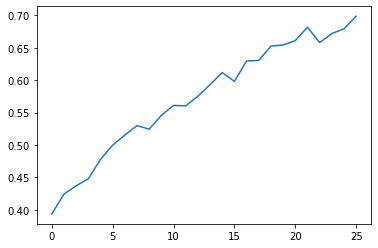

In [28]:
plt.plot(sil)
#plt.xlim([10, 15])

In [31]:
#ELBOW CURVE

# K-Means - finding K
distortions = []
K = range(1,100)
for k in K:
    print(k)
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=1)
    model.fit(features)
    distortions.append(model.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


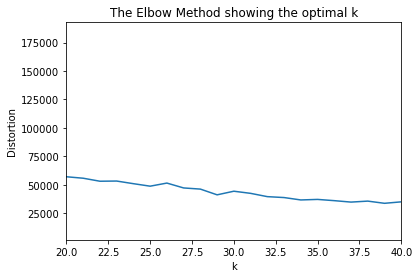

In [33]:
plt.plot(K, distortions, '-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.xlim([20, 40])
#plt.ylim([0, 17000])
plt.show()

In [ ]:
# 29 clusters for main topic

In [34]:
# KMeans - setting number of clusters
k = 29
model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=50)
model.fit(features)

KMeans(max_iter=1000, n_clusters=29, n_init=50)

In [35]:
# new column with cluster labels
items['main_topic_cluster'] = model.labels_

In [36]:
# check each cluster
items[['main topic', 'main_topic_cluster']].loc[items['main_topic_cluster'] == 10]

,main topic,main_topic_cluster
3,YB,10
48,YF,10
90,YF,10
110,YF,10
196,YF,10
...,...,...
76700,YF,10
76701,YF,10
76702,YF,10
76740,YF,10


In [38]:
### save description clusters to pickle file
with open('main_topic_clusters.pkl', 'wb') as f:
    pickle.dump(items, f)